In [101]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import os, time

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support import expected_conditions as EC

from bs4 import BeautifulSoup
from googletrans import Translator
import translators.server as tss

import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud
from fa2 import ForceAtlas2

import cred     #spotify developer account
import spotipy
from spotipy.oauth2 import SpotifyOAuth

In [ ]:
df_idols = pd.read_csv("./Dataset/kpop_idols.csv.xls")
df_group = df_idols.copy()
df_group.drop(columns=['Stage Name', 'Full Name', 'Korean Name', 'K. Stage Name',
                                    'Date of Birth', 'Country', 'Birthplace', 
                                    'Other Group','Gender'], inplace=True)
df_group.dropna(inplace=True)
df_group.reset_index(drop=True, inplace=True)

In [ ]:
# setting up the spotipy API
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=cred.client_ID, 
                                                client_secret=cred.client_SECRET, 
                                                redirect_uri=cred.redirect_url),
                        requests_timeout=30)

In [ ]:
# to increase the accuracy of the fetching result
# target genres are defined and using as constrain
# only when none genre matches will return the most possible result
target_genres = ['k-pop','k-pop girl group','k-pop boy group','k-rock',
                    'korean pop','korean city pop']

def sp_fetcher(name):
    result = sp.search(q='artist:' + name, type='artist')
    items  = result['artists']['items']
    for i in items:
        if (any(genre in i['genres'] for genre in target_genres)):
            return [i['name'], i['genres'], i['uri'], i['popularity']]
    if len(items) > 0:
        i = items[0]
        return [i['name'], i['genres'], i['uri'], i['popularity']]

In [ ]:
# fill the info into dataframe
for idx, name in enumerate(df_group['Group']):
    result = sp_fetcher(name)
    try:
        df_group.at[idx,'spotify_name'] = str(result[0])
        df_group.at[idx,'genres']       = list(result[1])
        df_group.at[idx,'uri']          = str(result[2])
        df_group.at[idx,'popularity']   = int(result[3])
    except TypeError:
        df_group.at[idx,'spotify_name'] = pd.NaT
        df_group.at[idx,'genres']       = pd.NaT
        df_group.at[idx,'uri']          = pd.NaT
        df_group.at[idx,'popularity']   = pd.NaT

In [ ]:
# clear up the dataframe
df_group.dropna(inplace=True)
df_group.drop_duplicates(subset=['Group'], keep='last', inplace=True)

In [ ]:
# show the top 20 groups
top_groups = df_group.sort_values(by=['popularity'])[-20:]
top_groups.sort_values(by=['popularity'], ascending=False)

We noticed that some of the groups have different names, IM leads to Imagine Dragons, TOO leads to TOOL, ANS leads to Anson Seabra, DUSTIN leads to Dustin Lynch, which are all wrong links.

This inaccuracy happens in two forms:
1. The artist exists on Spotify, but the API cannot fetch
2. The artist does NOT exist on Spotify

Both will result in returning the most likely option. After analynizing them, a overview can now be presented (The contained data is collected on November 24th, 2023):
| Group         | exist on Spotify | monthly listeners |
| ------------- |:----------------:| -----------------:|
| IM            | NO               |                 / |
| TOO           | YES              |            31,203 |
| ANS           | YES              |            21,350 |
| DUSTIN        | NO               |                 / |

We have checked the monthly listeners of Monsta X and BigBang, which both have popularity at 64, the numbers are 2,341,918 and 2,868,384. Comparing them together, due to the significant difference, we should not consider keeping these groups.

There is one exception that comes to noticed: NCT leads to NCT DREAM, which is correct but not entirely. Since NCT has different sub-units, such as NCT 127, NCT Dream, NCT U and WayV, which corespondingly have popularity at 71, 70, 63 and 58. 

We therefore decide to drop the foremetioned wrong links and manully place NCT 127.

In [ ]:
# dropping the aforementioned wrong links
df_group.drop([994, 1062, 808, 908], inplace=True)

In [ ]:
# manually adding NCT 127
group = 'NCT 127'
res = sp_fetcher(group)
nct = pd.DataFrame([[group, str(res[0]),list(res[1]),str(res[2]), int(res[3])]], 
                    columns=['Group','spotify_name','genres','uri','popularity'])
df_group = pd.concat([nct, df_group])

In [ ]:
# check the top 20 again
top_groups = df_group.sort_values(by=['popularity'])[-20:]
top_groups.sort_values(by=['popularity'], ascending=False, inplace=True)

We can tell that DIA leads Diana Krall is again a wrong link, so we repeat the previous process and get their monthly listeners number: 102,596, which indicates the removal of this group.

In [ ]:
df_group.drop([1089], inplace=True)

top_groups = df_group.sort_values(by=['popularity'])[-20:]
top_groups.sort_values(by=['popularity'], ascending=False, inplace=True)

In [ ]:
# !!!should later DELETE
os.makedirs('/Users/xyc/Desktop/', exist_ok=True)
top_groups.to_csv('/Users/xyc/Desktop/top20.csv')

In [ ]:
# !!!should later DELETE
top_groups = pd.read_csv('/Users/xyc/Desktop/top20.csv', engine='python')
top_groups.drop(columns=['Unnamed: 0'], inplace=True)

Now the international top 20 korea groups are in, next step will be fetching the top 10 songs for all of them

In [ ]:
# drop the redundant columns and clear up the dataframe
top_groups.drop(columns=['Group', 'genres'], inplace=True)
top_groups.sort_values(by=['popularity'], ascending=False, inplace=True)
top_groups.reset_index(drop=True, inplace=True)

In [ ]:
def song_fetcher(uri):
    song_list = []
    results   = sp.artist_top_tracks(uri)
    for track in results['tracks'][:10]:
        song = []
        song.append(track['name'])
        song.append(track['uri'])
        song.append(track['album']['name'])
        song.append(track['popularity'])
        song_list.append(song)
    return song_list

In [ ]:
top_groups['top10songs'] = top_groups.uri.apply(song_fetcher)

In [ ]:
df_track = pd.DataFrame(columns=['track', 'artists', 'uri', 'album_name', 'popularity'])
for idx, song_list in enumerate(top_groups['top10songs']):
    for s in song_list:
        df_song  = pd.DataFrame([[s[0], top_groups.at[idx, 'spotify_name'], s[1], s[2], s[3]]],
                                columns=['track', 'artists', 'uri', 'album_name', 'popularity'])
        df_track = pd.concat([df_song, df_track])

In [ ]:
df_track.sort_values(by=['popularity'], ascending=False, inplace=True)
df_track.reset_index(drop=True, inplace=True)

In [ ]:
def add_valence(uri):
    features = sp.audio_features(uri)
    valence  = features[0]['valence']
    return valence

df_track['valence'] = df_track.uri.apply(add_valence)

In [ ]:
# !!!should later DELETE
os.makedirs('/Users/xyc/Desktop/', exist_ok=True)
df_track.to_csv('/Users/xyc/Desktop/tracks.csv')

In [5]:
# !!!should later DELETE
df_track = pd.read_csv('/Users/xy/Desktop/tracks.csv', engine='python')
df_track.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
# popularity distribution
hist, edge    = np.histogram(df_track['popularity'], bins=20)
adjusted_edge =  (edge[:-1]+edge[1:])/2
plt.plot(adjusted_edge, hist, c='lightsalmon', marker='o')
plt.xlabel('popularity')
plt.ylabel('quantity')
plt.title('Distribution of the Popularity of 200 songs', 
            pad=10.0)
plt.show()

In [ ]:
# auto-login for spotify
chrome = webdriver.Chrome()
chrome.get('https://open.spotify.com/')
time.sleep(3)
chrome.find_element(By.ID, "onetrust-accept-btn-handler").click()
chrome.find_element(By.CSS_SELECTOR, ".jsmWVV").click()
time.sleep(2)
chrome.find_element(By.ID, "login-username").send_keys("luqiuyu2016@126.com") 
chrome.find_element(By.ID, "login-password").send_keys("LQY894580056")  
chrome.find_element(By.ID, "login-button").click()
time.sleep(1)

In [ ]:
def page_fetcher(browser, uri):
    baseurl = 'https://open.spotify.com/track/'
    browser.get(baseurl+uri)
    threshold = False
    composer, producer = [], []
    wait = WebDriverWait(browser, 20)

    prefix = 'Lyrics '
    try:
        wait.until(EC.presence_of_element_located((By.CLASS_NAME, 
                    "T0anrkk_QA4IAQL29get")))
        lyrics = browser.find_element(By. CLASS_NAME, 
                    "Q3OKWaFrTVTIRZyG05Gh").text.replace('\n', ' ')
        lyrics = lyrics.removeprefix(prefix)
    except NoSuchElementException:
        lyrics = 'Not Found'

    try:
        browser.find_element(By.CLASS_NAME, "T0anrkk_QA4IAQL29get").click()
        browser.find_element(By.XPATH, "//*[text()='Show credits']/parent::button").click()
        time.sleep(1)
    except NoSuchElementException:
        page_fetcher(browser, uri)
        
    try:
        soup    = BeautifulSoup(browser.page_source, "html.parser")
        credits = soup.find_all('div', attrs={"class":"beyOcd3p0PEzhrlKIbU1"})
        time.sleep(2)
        for c in credits[1]:
            composer.append(c.text)
        for p in credits[2]:
            producer.append(p.text)
        if len(composer)>1: 
            threshold = True
            composer.pop(0)
            producer.pop(0)
    except NoSuchElementException:
        page_fetcher(browser, uri)

    if threshold is not True:
        page_fetcher(browser, uri)

    return composer, producer, lyrics

In [ ]:
df_track['uri'] = df_track.uri.apply(lambda x: x.removeprefix('spotify:track:'))

In [ ]:
df_pages     = pd.DataFrame(columns=['uri', 'composer', 'producer', 'lyrics'])
for i in df_pages['uri']:
    info     = page_fetcher(chrome, i)
    df_info  = pd.DataFrame([[i, info[0], info[1], info[2]]], 
                                columns=['uri', 'composer', 'producer', 'lyrics'])
    df_pages = pd.concat([df_pages, df_info])

In [ ]:
# !!!should later DELETE
os.makedirs('/Users/xyc/Desktop/', exist_ok=True)
df_pages.to_csv('/Users/xyc/Desktop/pages_v1.csv')


In [2]:
# !!!should later DELETE
df_pages = pd.read_csv('/Users/xy/Desktop/pages_v1.csv', engine='python')
df_pages.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
# could be deleted
print(df_pages.value_counts(subset=['producer'])[:2])
print(df_pages.value_counts(subset=['composer'])[:2])

producer 
['-']        122
['TEDDY']      6
dtype: int64
composer                                                             
['-']                                                                    29
['BUDDY', 'EDEN', 'Kim Hongjoong', 'LEEZ', 'Ollounder', 'Song Mingi']     4
dtype: int64


In [16]:
ts = Translator()
def translate(l):
    source = ts.detect(l).lang
    if source == 'en':
        res = tss.google(l, to_language='en')
    else:
        res = tss.google(l, from_language=source,to_language='en')
    return res

In [17]:
# translate the lyrics to english
df_pages['translated'] = df_pages.lyrics.apply(lambda x: translate(x))

In [34]:
cnt, problems = 0, []
for idx, l in enumerate(df_pages['translated']):
    l = l.replace("♪", "")
    try:
        l.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        problems.append(idx)
        cnt+=1

Analyzing the songs [1, 12, 19, 23, 31, 42, 50, 53, 55, 64, 67, 68, 70, 74, 87, 88, 91, 97, 100, 113, 123, 128, 146, 150, 167, 169, 176, 179, 192] that did not get translate properly, they could have the following problem:
- still has korean characters: 12, 42, 50, 53, 67, 100, 113, 123, 128, 146
- has japanese characters: 42
- has chinese characters: 55, 97
- has french characters: 31, 68, 70, 150, 176
- has spanish characters: 64
- has romanization of korean: 23
- strange characters:  ㅠㅠ(74), ° F(192)
- cannot not tell: 1, 19, 87, 88, 91, 167, 169, 179

In [110]:
cnt, problems = 0, []
for idx, l in enumerate(df_pages['translated']):
    l = l.replace("♪", "")
    if idx in [12, 42, 50, 53, 67, 100, 113, 123, 128, 146]:
        print(idx)
        df_pages.at[idx, 'translated'] = tss.google(l, from_language='ko',to_language='en')
    if idx == 42:
        df_pages.at[idx, 'translated'] = tss.google(l, from_language='ja',to_language='en')
    if idx in [31, 68, 70, 150, 176]:
        print(idx)
        df_pages.at[idx, 'translated'] = l.replace("déjà", "deja")
        df_pages.at[idx, 'translated'] = l.replace("Déjà-Vu", "Deja vu")
        df_pages.at[idx, 'translated'] = l.replace("Déjà", "Deja")
    if idx == 64:
        df_pages.at[idx, 'translated'] = l.replace("piña", "pina")
    if idx == 192:
        df_pages.at[idx, 'translated'] = l.replace("° F", "Fahrenheit")
    if idx == 74:
        df_pages.at[idx, 'translated'] = l.replace("ㅠㅠ", "")
    try:
        l.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        problems.append(idx)
        cnt+=1

Now we want to check if some lyrics are missing a part of it

In [157]:
for idx, i in enumerate(df_pages['translated']):
    if idx not in [85, 123, 192]: 
        if abs(len(df_pages.at[idx, 'lyrics']) - len(i)) > 500:
            print(idx)
            print(df_pages.at[idx, 'lyrics'])
            print(i)

After fixing and checking session above, we have now 11 songs with special characters that human eyes cannot tell, which are [1, 19, 60, 85, 87, 88, 91, 123, 128, 169, 179].

Now we will proceed further.

In [9]:
# !!!should later DELETE
os.makedirs('/Users/xy/Desktop/', exist_ok=True)
df_pages.to_csv('/Users/xy/Desktop/pages_v4.csv')

In [39]:
# !!!should later DELETE
df_pages = pd.read_csv('/Users/xy/Desktop/pages_v4.csv', engine='python')
df_pages.drop(columns=['Unnamed: 0'], inplace=True)

In [12]:
# !!!should later DELETE
df_track = pd.read_csv('/Users/xy/Desktop/tracks_v2.csv', engine='python')
df_track.drop(columns=['Unnamed: 0'], inplace=True)

In [40]:
df = df_track.merge(df_pages)

In [42]:
# clear up function for the content
# returns only tokens NOT in stopwords
def clear_up(content):
    try:
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        wordsOnly = tokenizer.tokenize(content)
        tokens    = [w for w in wordsOnly if not w.lower() 
                        in stopwords.words('english')]
    except:
        tokens    = []
    return tokens

# shorten fucntion for lemamation
# can only handle one word at a time
# it will "purify" the tokens
lemmatizer = nltk.wordnet.WordNetLemmatizer()
lemma      = lemmatizer.lemmatize

In [49]:
group_list = df.artists.unique()
cloud_list = []
for i in group_list:
    collection = df.translated[df.artists.isin([i])].to_string()
    collection = lemma(collection)
    wordcloud = WordCloud(max_font_size=50, max_words=100,
                            stopwords=stopwords.words('english'),
                            background_color="white").generate(collection)
    cloud_list.append(wordcloud)


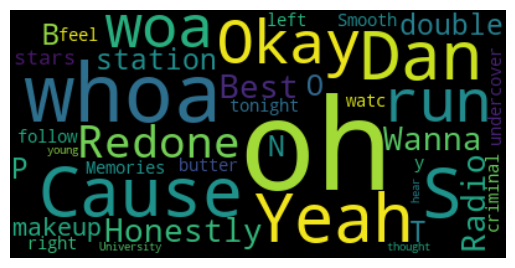

In [35]:
# Display the generated image:
plt.imshow(cloud_list[0], interpolation='bilinear')
plt.axis("off")
plt.show()

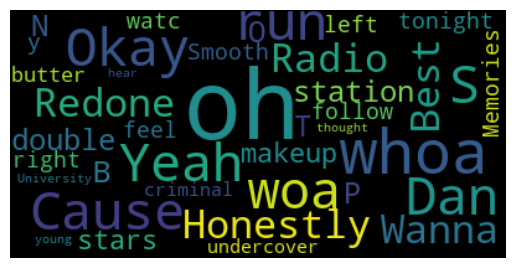

In [44]:
# Display the generated image:
plt.imshow(cloud_list[0], interpolation='bilinear')
plt.axis("off")
plt.show()

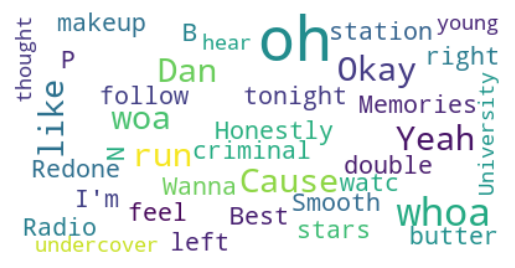

In [50]:
# Display the generated image:
plt.imshow(cloud_list[0], interpolation='bilinear')
plt.axis("off")
plt.show()

In [53]:
import spacy
!python -m spacy download en_core_web_md 

# !python -m spacy download en_core_web_sm      #for small
# !python -m spacy download en_core_web_md      #for medium  
# !python -m spacy download en_core_web_lg      #for large  

def sim_cal(i, rest):
    nlp  = spacy.load("en_core_web_md") 
    doc1 = nlp(i)
    sc   = []  
    for j in rest:
        doc2 = nlp(j)
        sc.append(doc1.similarity(doc2))
    return sc

In [57]:
df['similarity'] = df.translated.apply(lambda x: sim_cal(x, df['translated']))

In [74]:
# !!!should later DELETE
os.makedirs('/Users/xy/Desktop/', exist_ok=True)
df.to_csv('/Users/xy/Desktop/df_v1.csv')

We need to take a closer look at the similarity

In [87]:
mins, maxs, avgs = [],[],[]
for i in df['similarity']:
    s = i
    s = [num for num in s if num not in [1]]
    minimun, maximun, avg = min(s), max(s), np.mean(s)
    mins.append(minimun)
    maxs.append(maximun)
    avgs.append(avg)

In [79]:
print('|'.rjust(20, ' '), 'min'.center(10),'|','max'.center(10),
        '|','avg'.center(10),'|')
print('min of'.center(18),'|', str(round(min(mins),4)).center(10),
        '|',str(round(min(maxs),4)).center(10),'|',str(round(min(avgs),4)).center(10),'|')
print('max of'.center(18),'|', str(round(max(mins),4)).center(10),
        '|',str(round(max(maxs),4)).center(10),'|', str(round(max(avgs),4)).center(10),'|')
print('avg of'.center(18),'|', str(round(np.mean(mins),4)).center(10),
        '|',str(round(np.mean(maxs),4)).center(10),'|', str(round(np.mean(avgs),4)).center(10),'|')

                   |    min     |    max     |    avg     |
      min of       |   0.0681   |   0.5612   |   0.3811   |
      max of       |   0.5191   |   0.9844   |   0.8714   |
      avg of       |   0.3199   |   0.9408   |   0.7898   |


In [92]:
from itertools import chain
all_sc = list(chain(mins,maxs,avgs))

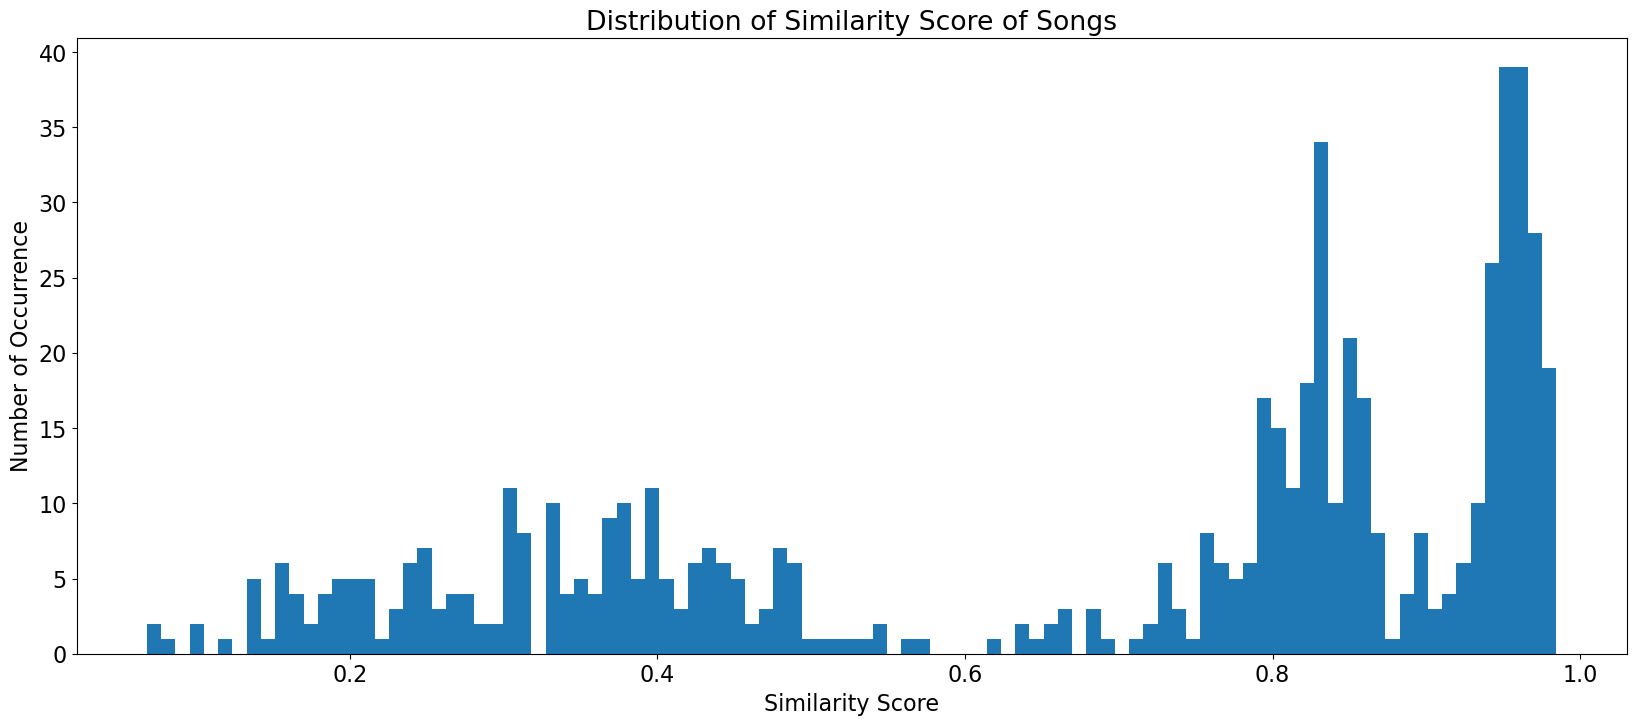

In [100]:
bins = np.linspace(min(all_sc), max(all_sc), 100)
plt.figure(figsize = (20, 8))
plt.rc('font', size=16)
plt.hist(all_sc, bins)
plt.title('Distribution of Similarity Score of Songs')
plt.xlabel('Similarity Score')
plt.ylabel('Number of Occurrence')
plt.show()

Find the critical point, decide where definds the significant.
0.7? 0.8?

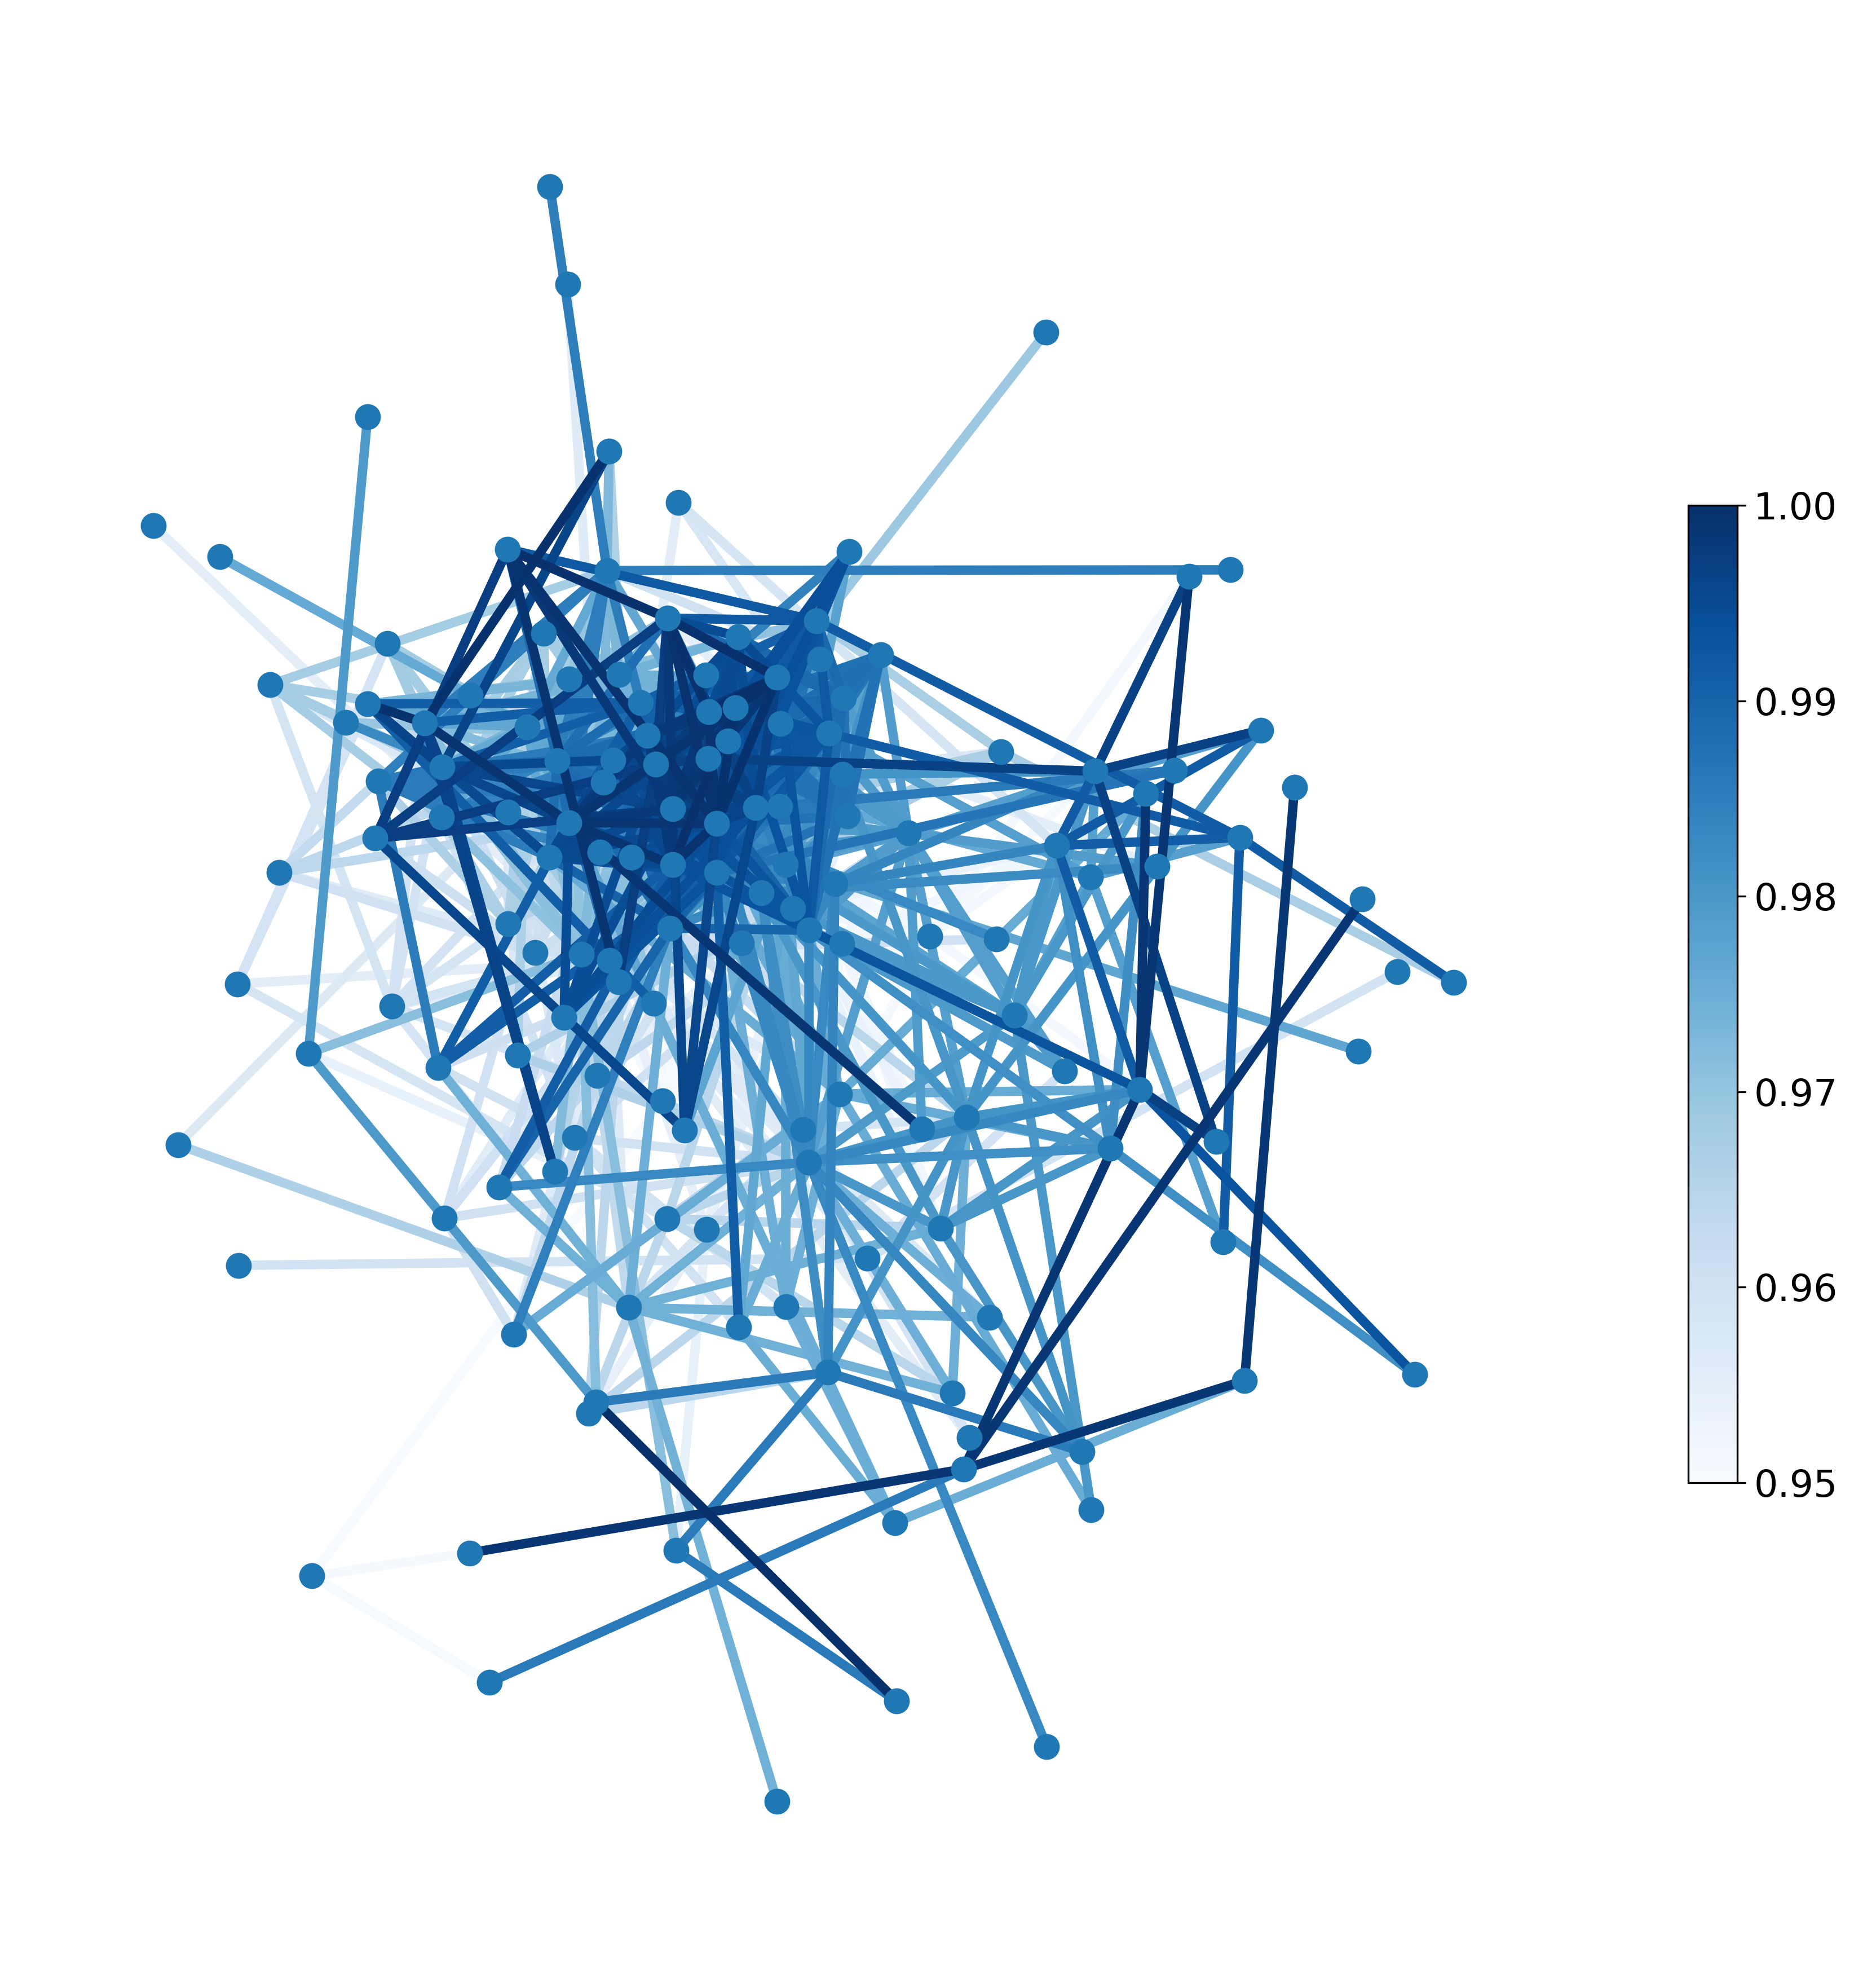

In [156]:
fig = plt.figure(figsize=(15,15), dpi=300)
G   = nx.Graph()

for idx,i in enumerate(df['similarity']):
    for iidx,sc in enumerate(i):
        if sc > 0.95:
            G.add_edge(idx, iidx)

G.remove_edges_from(nx.selfloop_edges(G))

colors  = range(200)
pos     = nx.spring_layout(G, scale=.8, k=1/2, seed=2895)

sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0.95, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.5)

nx.draw(G, pos, edge_color=range(G.number_of_edges()), node_size=100, edge_cmap=plt.cm.Blues, width=4)
plt.show()

100%|██████████| 2000/2000 [00:00<00:00, 3615.54it/s]


BarnesHut Approximation  took  0.26  seconds
Repulsion forces  took  0.05  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


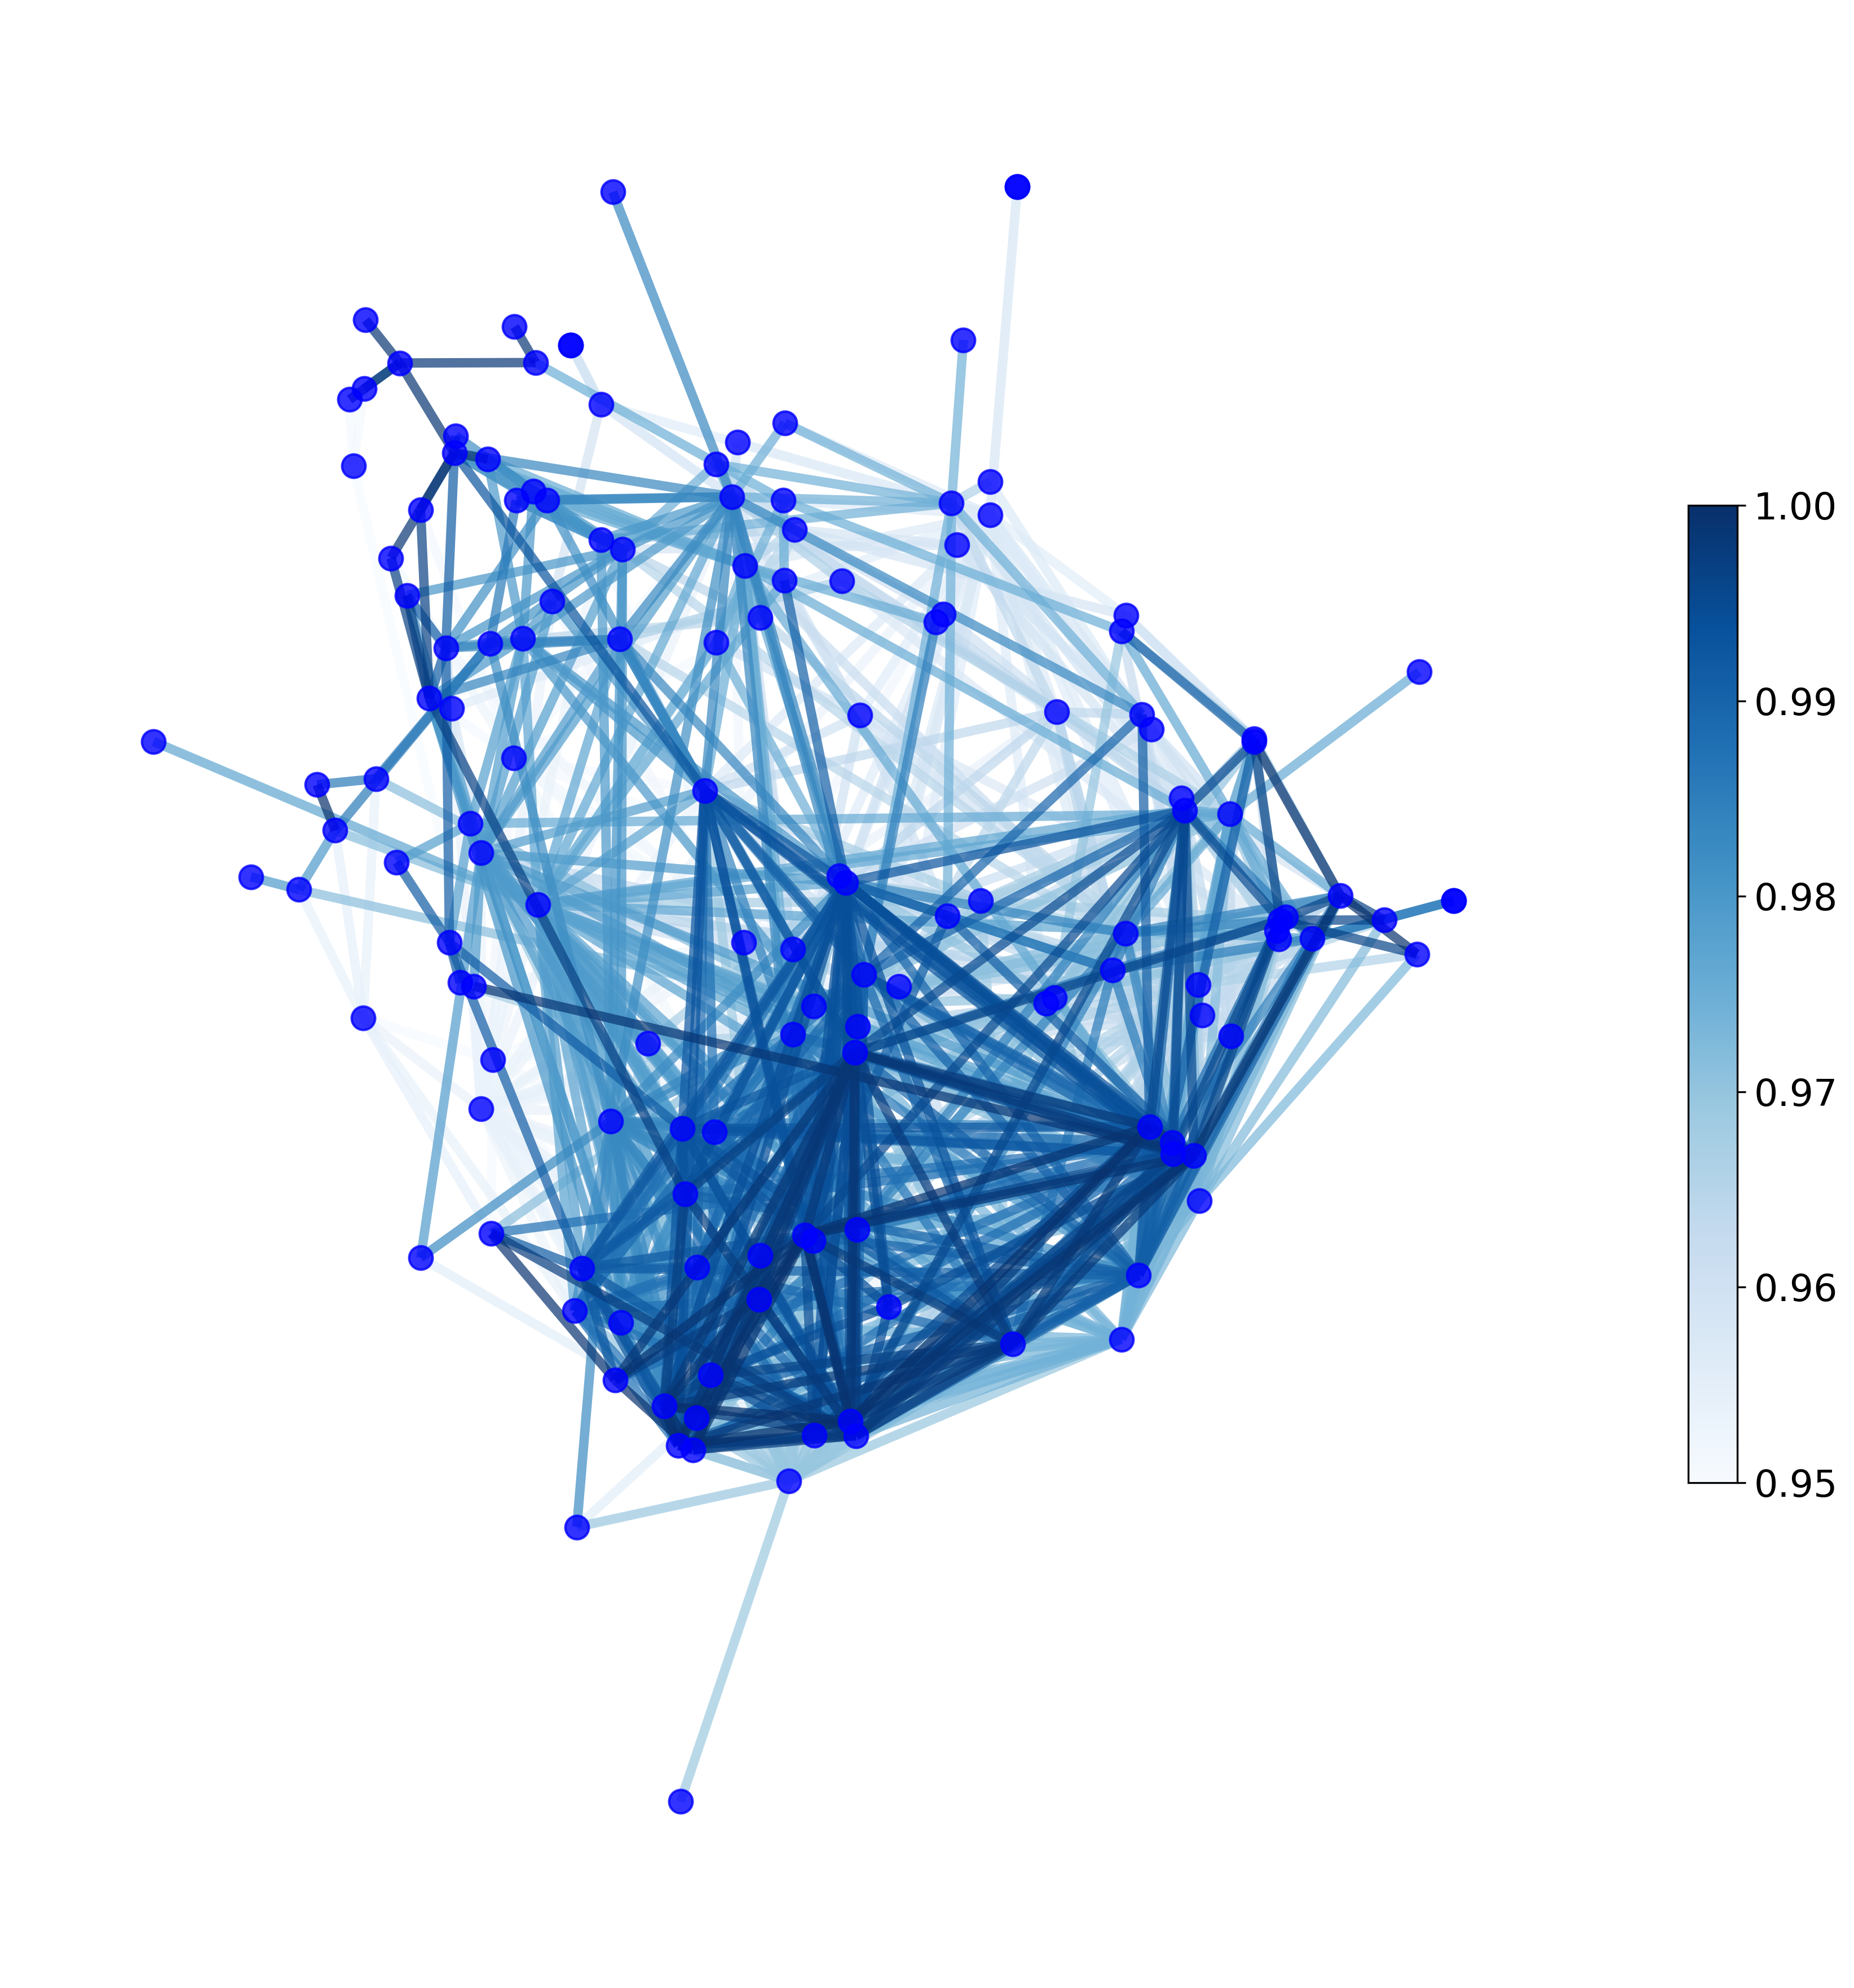

In [168]:
fig = plt.figure(figsize=(15,15), dpi=300)

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=5,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0.95, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.5)

nx.draw_networkx_nodes(G, positions, node_size=100, node_color="blue", alpha=.8)
nx.draw_networkx_edges(G, positions, edge_color=range(G.number_of_edges()), edge_cmap=plt.cm.Blues, alpha=.7, width=4)
plt.axis('off')
plt.show()

Now we are ready to calculate the sentiment score.

In [3]:
# get the data set from source
sen = 'https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0026752.s001'
df_sen = pd.read_csv(sen, sep='\t', header = 2, 
                        usecols=['word', 'happiness_average'],
                        engine='python')

# a dict for the sentiment score 
# every item in form of k,v: (word, score) 
senDict = {df_sen.at[i,'word']: float(df_sen.at[i,'happiness_average']) 
                for i in range(df_sen.shape[0])}

In [41]:
# clear up function for the content
# returns only tokens NOT in stopwords
def clear_up(content):
    try:
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        wordsOnly = tokenizer.tokenize(content)
        tokens    = [w for w in wordsOnly if not w.lower() 
                        in stopwords.words('english')]
    except:
        tokens    = []
    return tokens

# shorten fucntion for lemamation
# can only handle one word at a time
# it will "purify" the tokens
lemmatizer = nltk.wordnet.WordNetLemmatizer()
lemma      = lemmatizer.lemmatize

In [20]:
# transforming lyrics into clear tokens
df_pages['tokens'] = df_pages.translated.apply(lambda x: clear_up(x)) 
df_pages['tokens'] = df_pages.tokens.apply(lambda x: [lemma(i) for i in x])

In [21]:
# !!!should later DELETE
os.makedirs('/Users/xy/Desktop/', exist_ok=True)
df_pages.to_csv('/Users/xy/Desktop/pages_v5.csv')

In [9]:
# !!!should later DELETE
df_pages = pd.read_csv('/Users/xy/Desktop/pages_v5.csv', engine='python')
df_pages.drop(columns=['Unnamed: 0'], inplace=True)

In [22]:
# keep only the tokens with score
# and have frequences of them
df_pages['tokens'] = df_pages.tokens.apply(lambda x: list(set(x) &
                                        set(senDict.keys())))
df_pages['tf']     = df_pages.tokens.apply(FreqDist)

In [23]:
# mark the length of tf list for later calculation
# have sentiment set with both values and tokens
# recalculate the sentiment after total score is in
df_pages['numOftf']   = df_pages.tf.apply(len)
df_pages['sentiment'] = df_pages.tf.apply(lambda x:
                                        {k: senDict[k]*v for k,v in x.items()})
df_pages['totalSentiment'] = df_pages.sentiment.apply(lambda x: sum(x.values()))
df_pages['sentiment']      = df_pages['totalSentiment']/df_pages['numOftf']

In [25]:
def stats(df):
    df.mean = np.mean(df['sentiment'], axis=0)
    df.min  = np.min(df['sentiment'], axis=0)
    df.max  = np.max(df['sentiment'], axis=0)
    print(df.mean, df.min, df.max)

In [26]:
stats(df_pages)

5.592300939169515 4.845384615384615 6.348717948717948


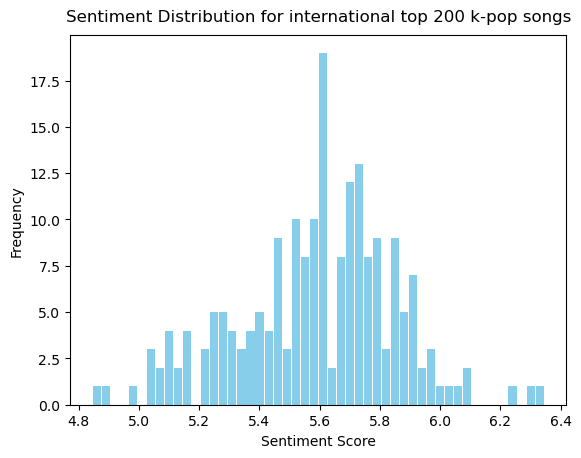

In [33]:
dist = dict(zip(list(df_pages.uri.values), list(df_pages.sentiment.values)))
v    = np.arange(min(df_pages.sentiment), max(df_pages.sentiment), step=.03)

# plotting
plt.hist(dist.values(), v, color='skyblue', rwidth=.9)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution for international top 200 k-pop songs', pad=10.0)
plt.show()

In [34]:
# !!!should later DELETE
os.makedirs('/Users/xy/Desktop/', exist_ok=True)
df_pages.to_csv('/Users/xy/Desktop/pages_v6.csv')

In [ ]:
# !!!should later DELETE
df_pages = pd.read_csv('/Users/xy/Desktop/pages_v6.csv', engine='python')
df_pages.drop(columns=['Unnamed: 0'], inplace=True)